### Machine learning workflow


1. data (prepare and load)
2. build model,
3. fitting the model to data (training),
4. making predictions and evaluating a model (inference),
5. saving and loading a model,
6. Putting it all together




In [26]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
# Check PyTorch version
torch.__version__


'2.5.1'

Turn your data, whatever it is, into numbers (a representation).
Pick or build a model to learn the representation as best as possible.

For examle lets pick a know param and check if the model can get the results

In [28]:
# Create *known* parameters
weight = 0.7
bias = 0.3


# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10] , len(X),len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

X (features) and y (labels)

### Split data into training and test sets

80% of data used for training set, 
20% Validation set
20% for testing 

In [31]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split] # upto train_split
X_test, y_test = X[train_split:], y[train_split:] #from train_split

len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

### Visualize the data

In [33]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    plt.figure(figsize=(10, 7))
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=8, label="Training data")
    #plot test data 
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    plt.legend(prop={"size": 14});

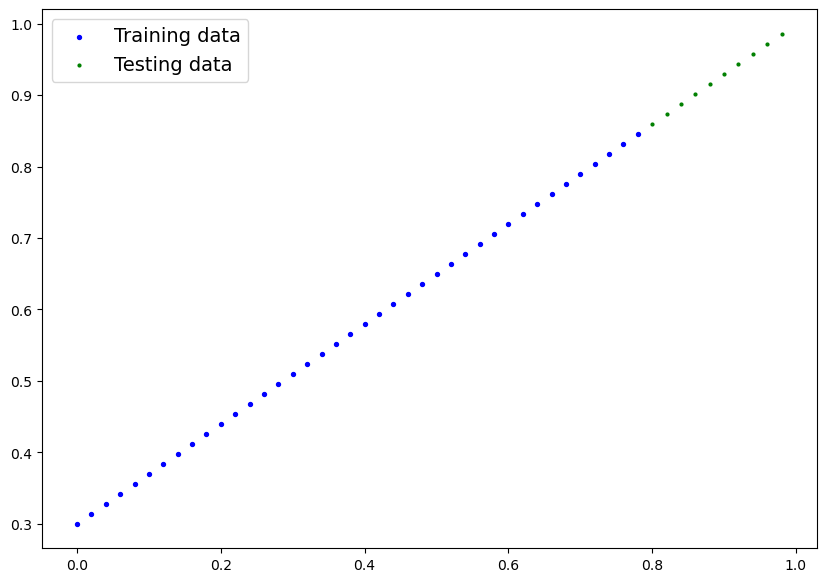

In [34]:
plot_predictions();

### Build model
Linear Regression model

In [36]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        #starting with random weight "1"
        self.weights = nn.Parameter(torch.randn(1),requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1),requires_grad=True)
        
    # Forward defines the computation in the model (required for all subclass for nn.Module)
    def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is the input data return tensor
        return self.weights * x + self.bias #linear regression formula (y = m*x + b)


### PyTorch model building essentials

1. nn.Module contains the larger building blocks (layers)
2. nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
3. def forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s) all models is required.
4. torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data


### Contents of a PyTorch model

In [39]:
# Create Random seed
torch.manual_seed(42)

model_O = LinearRegressionModel()

# to only access attributes
# print(model_O.__dict__.keys())



import inspect

#List all calss methods and members using the vars function
print(vars(model_O))

list(model_O.parameters())



{'training': True, '_parameters': {'weights': Parameter containing:
tensor([0.3367], requires_grad=True), 'bias': Parameter containing:
tensor([0.1288], requires_grad=True)}, '_buffers': {}, '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': {}}


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [40]:
print(model_O.state_dict())

OrderedDict({'weights': tensor([0.3367]), 'bias': tensor([0.1288])})


### Making predictions

In [42]:
X_test , y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [61]:
# Make predictions with model 
#inference mode turns off the tracking of gradient
# so u don't train it on testing data 
with torch.inference_mode(): 
    y_preds = model_O(X_test)

y_preds

list(model_O.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

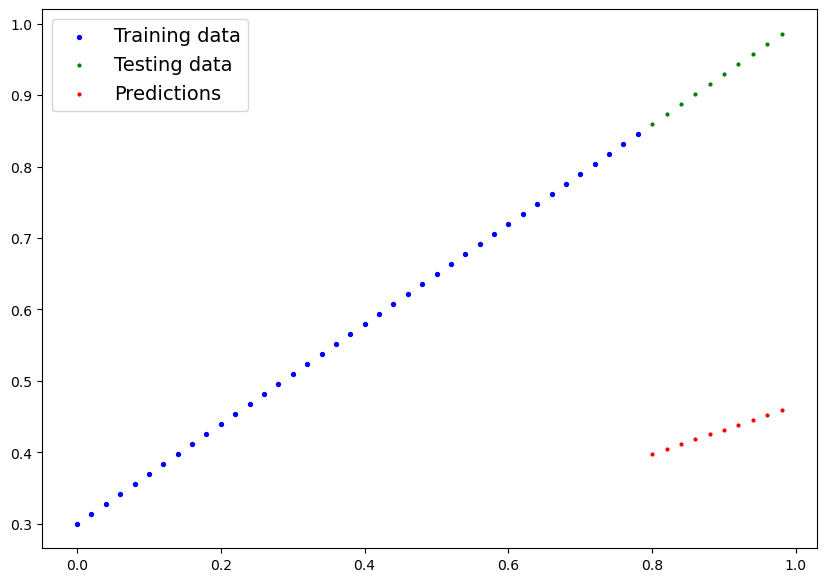

In [44]:
plot_predictions(predictions=y_preds)

### Training Model 
with the loss function (lower is better)
Optimizer tells model how to update its internal parameters to best lower the loss.

In [63]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup Optimizer
opt = torch.optim.SGD(model_O.parameters(),lr=0.01) #lr = learning Rate (Hyper parameter)

## Building the training Loop for the model
1. forward pass
2. calculate the loss
3. zero the gradient (PyTorch, by default, accumulates gradients. so we make it zero bcoz we need the gradient for that data pt to be accurate)
4. Perform backpropogation on the loss
5. update the optimizer (gradient descent)

In [86]:
epochs = 10000 # epoch is the number of iteration of the training loop

for epoch in range(epochs):
    #put model in training mode; Set the module in training mode.
    model_O.train()
    # 1. Forward pass on train data
    y_pred = model_O(X_train)
    # 2. calculate the loss 
    loss = loss_fn(y_pred, y_train)
    # 3. Zero grad of the optimizer yeah
    opt.zero_grad()
    # 4. Loss backwards
    loss.backward()
    # 5. Progress the optimizer
    opt.step()
    # Put the model in evaluation mode for testing phase
    model_O.eval()

print(model_O.state_dict())

OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})


In [76]:
weight,bias

(0.7, 0.3)

In [88]:
with torch.inference_mode(): 
    y_preds_new = model_O(X_test)

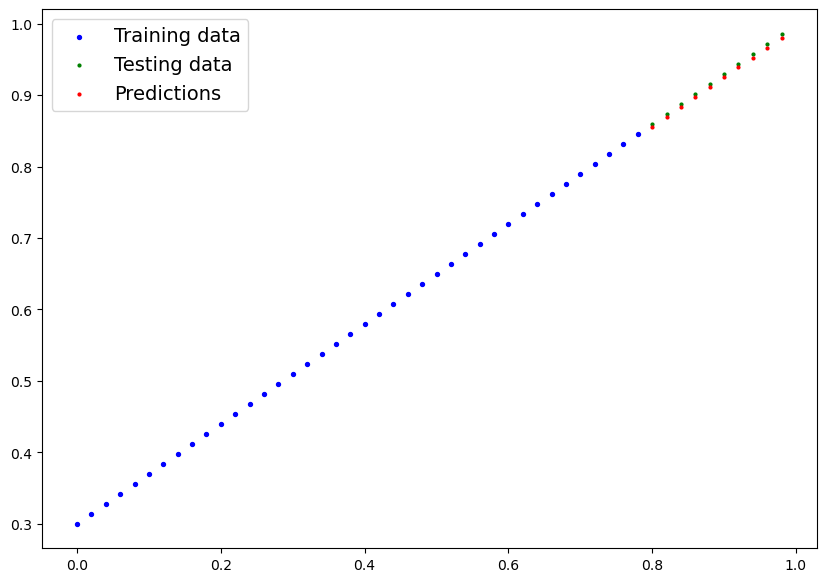

In [92]:
plot_predictions(predictions=y_preds_new)